**This notebook borrows most of the code of Scatterplot. Its objective is to test different parameters for the clusterization of DBSCAN and HDBSCAN.**

Code for chunks shared with the Scatterplot notebook are the same. The descriptions of what each subsection does are omitted for those shared chunks.

### Distance & ID Load

In [1]:
%pylab inline
import umap

Populating the interactive namespace from numpy and matplotlib


#### Data can be loaded two ways. Use either the chunks below for load as an npy matrix (chunk just below DBSCAN)

In [2]:
#We load the distance matrix, which was generated in a phyllip format. Each row has the name of a sample and then the
#distances to all of the samplea above it in the file.
phy=open("MashTriangle/secondCombinedDistances.phyllip","r",encoding="utf-8")

#There are a total of 13589 samples for now (this can be seen in the first line of the phyllip file).
distances=np.zeros((13589,13589))
#We'll save the sample ids in a list and the distances in distances.
ids=[]

#We'll need a counter to fill the distance matrix.
i=-2
for line in phy:
#At the beggining of each line we increase the counter by 1.
    i+=1
#The first line of the file contains only the total number of samples so we ignore it (when we read the first line,
#i=-1).
    if i<0:
        continue
#The second line has just the id of the first samples. We simply save the id and that's it.
    if i==1:
        line=line.strip("\n").split("\t")
        ids.append(line[0].split(".gz")[0].split("/")[1])
        continue
    
#The rest of the lines have distances. In particular the nth id has n-1 distances (for the n-1 samples above it). 
#First we get the id.
    line=line.strip("\n").split("\t")
    ids.append(line[0].split(".gz")[0].split("/")[1])
#Then we add the n-1 distances to the nth line and the nth column (the distance matrix is symmetrical).
    dist=asarray([float(x) for x in line[1::]])
    distances[0:i,i]=dist
    distances[i,0:i]=dist
    
phy.close()

In [3]:
np.isnan(np.min(distances))

False

#### If ID deduplication needs not be done omit the two cells below

In [4]:
#We might be interested in deduplicating the data, as some of the samples might be present in more than one
#database.

#For that we can look at the distance matrix and look for samples with mash distance of 0.

#We'll save the samples to be deleted in toDelete and their positions in the id list in PositionstoDelete.
SampletoDelete=[]
PositionstoDelete=[]

#Now we iterate over the distance matrix. 
for i in range(0,len(ids)):
    for j in range(i,len(ids)):
#If a given pair of samples have a mash distance of 0, we add the id and position of the second one in the 
#corresponding lists for deletion.
        if i!=j and distances[i,j]==0:
            SampletoDelete.append(ids[j])
            PositionstoDelete.append(j)

In [5]:
#We dereplicate SampletoDelete and PositionstoDelete incase a given sample appear more than once.
SampletoDelete=list(set(SampletoDelete))
len(SampletoDelete)

PositionstoDelete=list(set(PositionstoDelete))
len(PositionstoDelete)

31

In [6]:
#We delete the ids of the duplicated from ids. We dereplicate the list just in case.

for sample in SampletoDelete:
    try:
        ids.remove(str(sample))
    except:
        continue
    
#We remove the row and columns of the duplicated ids from the distance matrix.
distances=np.delete(distances,PositionstoDelete,axis=0)
distances=np.delete(distances,PositionstoDelete,axis=1)

#### Load npy matrix (if necessary)

In [14]:
distances=np.load("cluster1.npy")

## Clustering Parameter Analyses

Here the different parameters of DBSCAN and HDBSCAN are tested and compared.

#### dbSCAN

In [15]:
#We'll begin with DBSCAN. We also load the solhouette score.
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

#We define the parameters to be tested. Here we'll only vary the (soft lock on) maximum distance between points of the
#same cluster, and the number of samples close to a sample to be considered the center of a cluster.
eOpt=[0.05,0.075,0.1,0.12,0.15,0.2,0.25,0.3,0.35]
#MSamples=[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]
#MSamples=[1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000]
MSamples=[1,10,25,50,65,75,90,100,115,125,150,175,200,225,250]

#We'll save the results of the best output. We'll measure the best one as that which minimizes the distances 
#between members of the same cluster. We don't minimize the median distance between members of the same and 
#different clusters as this might favor a low intercluster distance.

#The parameters to be saved are the intra cluster distance, the number of clusters, and the difference between the 
#inter and intra cluster distances.
#bestEOpt=0
#bestMSamples=0
#leastSame=1000000000
#leastInter=0

#We'll also save the output from every possible combination of parameters.
#AllDiff=[]
#AllSameDist=[]
NumClusters=[]
SS=[]

#Now we test the parameters. We try every possible combination.
for EO in eOpt:
    print(EO)
    for MS in MSamples:
        print(MS)
#For each we generate the clusterization using the Mash distance data.
        dbg=DBSCAN(eps=EO,metric="precomputed",min_samples=MS).fit(distances)
#We go over the distance matrix and save inter cluster distances in group_distances and intra cluster distances in
#diff_distances.
        #group_distances=[]
        #diff_distances=[]

        #for i in range(1,distances.shape[0]):
        #    for j in range(0,i):
        #        if dbg.labels_[i]==dbg.labels_[j]:
        #            group_distances.append(distances[i,j])
        #        else:
        #            diff_distances.append(distances[i,j])
        
#We save the values in the adequate lists.
        #thisDiff=mean(diff_distances)-mean(group_distances)
        #thisDist=mean(group_distances)
        NumClusters.append((max(dbg.labels_)+2))
        #AllDiff.append(thisDiff)
        #AllSameDist.append(thisDist)
        filterDist=distances[dbg.labels_!=-1,]
        filterDist=filterDist[:,dbg.labels_!=-1]
        try:
            #ss=silhouette_score(filterDist,dbg.labels_[dbg.labels_>-1],metric='precomputed')
            ss=silhouette_score(filterDist,dbg.labels_[dbg.labels_>-1],metric='precomputed')
            print(ss)
            SS.append(ss)
        except ValueError:
            print(-1)
            SS.append(-1)
        del dbg
#As a failsafe, we make sure that the median intra group distance is smaller than the median inter group distance.
        #if median(diff_distances)<=median(group_distances):
        #    continue

#If the median intra cluster distance is smaller than the smallest one so far, the parameters for the best 
#clusterization are updated.
        #if thisDist<leastSame:
        #    bestEOpt=EO
        #    bestMSamples=MS
        #    leastSame=thisDist
        #    leastInter=thisDiff

0.05
1
0.06854957633465679
10
0.5449151791708935
25
-1
50
-1
65
-1
75
-1
90
-1
100
-1
115
-1
125
-1
150
-1
175
-1
200
-1
225
-1
250
-1
0.075
1
0.1373090336886286
10
0.3151455465166551
25
0.50206429357446
50
-1
65
-1
75
-1
90
-1
100
-1
115
-1
125
-1
150
-1
175
-1
200
-1
225
-1
250
-1
0.1
1
-0.18626066957862478
10
-0.0574979329552328
25
0.13605323125204316
50
-1
65
0.2634614813259464
75
0.2721512780290114
90
0.32200703580691825
100
0.3600805541333537
115
-1
125
-1
150
-1
175
-1
200
-1
225
-1
250
-1
0.12
1
-0.08819837839283977
10
0.17114962907867498
25
-1
50
-1
65
-1
75
-1
90
-1
100
-1
115
-1
125
-1
150
-1
175
-1
200
-1
225
-1
250
-1
0.15
1
-1
10
-1
25
-1
50
-1
65
-1
75
-1
90
-1
100
-1
115
-1
125
-1
150
-1
175
-1
200
-1
225
-1
250
-1
0.2
1
-1
10
-1
25
-1
50
-1
65
-1
75
-1
90
-1
100
-1
115
-1
125
-1
150
-1
175
-1
200
-1
225
-1
250
-1
0.25
1
-1
10
-1
25
-1
50
-1
65
-1
75
-1
90
-1
100
-1
115
-1
125
-1
150
-1
175
-1
200
-1
225
-1
250
-1
0.3
1
-1
10
-1
25
-1
50
-1
65
-1
75
-1
90
-1
100
-1
115


In [8]:
#We print the parameters of the best models.
print(bestEOpt)
print(bestMSamples)
print(leastSame)
print(leastInter)

0.05
1
0.07944422523994979
0.3371637647666449


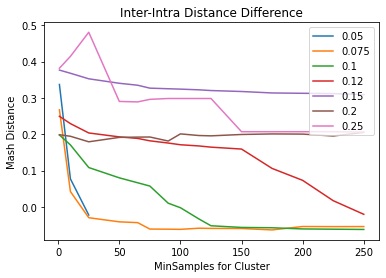

In [13]:
#Now we graph the behaviour of model performance. Here, difference in median intra and inter cluster distance.
eOpt=[0.05,0.075,0.1,0.12,0.15,0.2,0.25]
plot(MSamples,AllDiff[0:15],label="0.05")
plot(MSamples,AllDiff[15:30],label="0.075")
plot(MSamples,AllDiff[30:45],label="0.1")
plot(MSamples,AllDiff[45:60],label="0.12")
plot(MSamples,AllDiff[60:75],label="0.15")
plot(MSamples,AllDiff[75:90],label="0.2")
plot(MSamples,AllDiff[90:105],label="0.25")

title("Inter-Intra Distance Difference")
xlabel("MinSamples for Cluster")
ylabel("Mash Distance")
legend(loc=1)

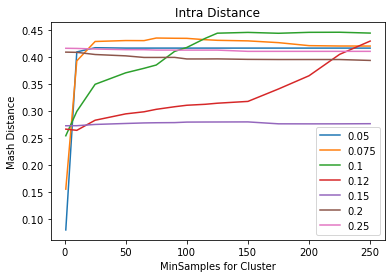

In [14]:
#Next, intra cluster median distance.
eOpt=[0.05,0.075,0.1,0.12,0.15,0.2,0.25]
plot(MSamples,AllSameDist[0:15],label="0.05")
plot(MSamples,AllSameDist[15:30],label="0.075")
plot(MSamples,AllSameDist[30:45],label="0.1")
plot(MSamples,AllSameDist[45:60],label="0.12")
plot(MSamples,AllSameDist[60:75],label="0.15")
plot(MSamples,AllSameDist[75:90],label="0.2")
plot(MSamples,AllSameDist[90:105],label="0.25")
title("Intra Distance")
xlabel("MinSamples for Cluster")
ylabel("Mash Distance")
legend()

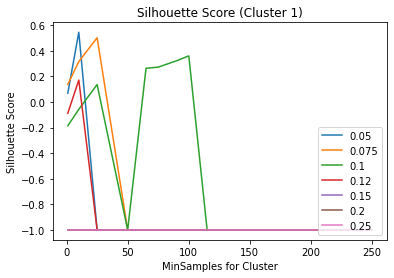

In [16]:
#Now the silhouette score.
plot(MSamples,SS[0:15],label="0.05")
plot(MSamples,SS[15:30],label="0.075")
plot(MSamples,SS[30:45],label="0.1")
plot(MSamples,SS[45:60],label="0.12")
plot(MSamples,SS[60:75],label="0.15")
plot(MSamples,SS[75:90],label="0.2")
plot(MSamples,SS[90:105],label="0.25")
title("Silhouette Score (Cluster 1)")
xlabel("MinSamples for Cluster")
ylabel("Silhouette Score")
#yscale("log")
legend(loc=4)

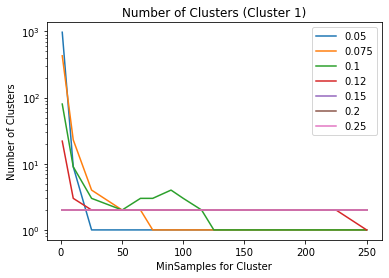

In [17]:
#Finally, the number of clusters.
eOpt=[0.05,0.075,0.1,0.12,0.15,0.2,0.25]
plot(MSamples,NumClusters[0:15],label="0.05")
plot(MSamples,NumClusters[15:30],label="0.075")
plot(MSamples,NumClusters[30:45],label="0.1")
plot(MSamples,NumClusters[45:60],label="0.12")
plot(MSamples,NumClusters[60:75],label="0.15")
plot(MSamples,NumClusters[75:90],label="0.2")
plot(MSamples,NumClusters[90:105],label="0.25")
title("Number of Clusters (Cluster 1)")
xlabel("MinSamples for Cluster")
ylabel("Number of Clusters")
yscale("log")
legend()

#### hdbSCAN

In [20]:
#Now the same thing with HDBSCAN. Comments are the same when the code is the same or equivalent.
import hdbscan
from sklearn.metrics import silhouette_score

#del hdbg
#del group_distances
#del diff_distances

#del hdbg
#del group_distances
#del diff_distances
#The parameters tested are the same. 
eOpt=[0.05,0.075,0.1,0.12,0.15,0.2,0.25]
#MSamples=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
MSamples=[1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000]

#We'll save the results of the best output. We'll measure the best one as that which minimizes the distances 
#between members of the same cluster. We don't minimize the median distance between members of the same and 
#different clusters as this might favor a low intercluster distance.

#The parameters to be saved are the intra cluster distance, the number of clusters, and the difference between the 
#inter and intra cluster distances.
HbestEOpt=0
HbestMSamples=0
HleastSame=1000000000
HleastInter=0

#We'll also save the output from every possible combination of parameters.
HAllDiff=[]
HAllSameDist=[]
HNumClusters=[]
HSS=[]

#Now we test the parameters. We try every possible combination.
for EO in eOpt:
    for MS in MSamples:
#For each we generate the clusterization using the Mash distance data.
        hdbg=hdbscan.HDBSCAN(eps=EO,metric="precomputed",min_samples=MS)
#We go over the distance matrix and save inter cluster distances in group_distances and intra cluster distances in
#diff_distances.
        cluster_labels = hdbg.fit_predict(distances)
        group_distances=[]
        diff_distances=[]

        for i in range(1,distances.shape[0]):
            for j in range(0,i):
                if cluster_labels[i]==cluster_labels[j]:
                    group_distances.append(distances[i,j])
                else:
                    diff_distances.append(distances[i,j])
#We save the values in the adequate lists.
        HthisDiff=mean(diff_distances)-mean(group_distances)
        HthisDist=mean(group_distances)
        HNumClusters.append((max(cluster_labels)+2))
        HAllDiff.append(HthisDiff)
        HAllSameDist.append(HthisDist)
        try:
            ss=silhouette_score(distances,hdbg.labels_,metric='precomputed')
            print(ss)
            HSS.append(ss)
        except ValueError:
            print(-1)
            HSS.append(-1)
        del hdbg

#As a failsafe, we make sure that the median intra group distance is smaller than the median inter group distance.
        if median(diff_distances)<=median(group_distances):
            continue
        
        del group_distances
        del diff_distances
#If the median intra cluster distance is smaller than the smallest one so far, the parameters for the best 
#clusterization are updated.            
        if HthisDist<HleastSame:
            HbestEOpt=EO
            HbestMSamples=MS
            HleastSame=HthisDist
            HleastInter=HthisDiff

-0.11478401140109963
-0.23142824908910517
-0.14316682485915652
-0.1780704488871939
-0.20806455712704763
-0.1460476008960713
0.5772720089446466
0.5720163366974098
0.5717568249794962
0.5702933735878013
0.5710307441946677
0.570946474026756
0.5685269428719659
0.5387322305057608
0.5479240636602811
-0.11478401140109963
-0.23142824908910517
-0.14316682485915652
-0.1780704488871939
-0.20806455712704763
-0.1460476008960713
0.5772720089446466
0.5720163366974098
0.5717568249794962
0.5702933735878013
0.5710307441946677
0.570946474026756
0.5685269428719659
0.5387322305057608
0.5479240636602811
-0.11478401140109963
-0.23142824908910517
-0.14316682485915652
-0.1780704488871939
-0.20806455712704763
-0.1460476008960713
0.5772720089446466
0.5720163366974098
0.5717568249794962
0.5702933735878013
0.5710307441946677
0.570946474026756
0.5685269428719659
0.5387322305057608
0.5479240636602811
-0.11478401140109963
-0.23142824908910517
-0.14316682485915652
-0.1780704488871939
-0.20806455712704763
-0.14604760089

In [21]:
#We print the parameters of the best models.
print(HbestEOpt)
print(HbestMSamples)
print(HleastSame)
print(HleastInter)

0.05
100
0.2374057015302246
0.19407015170747977


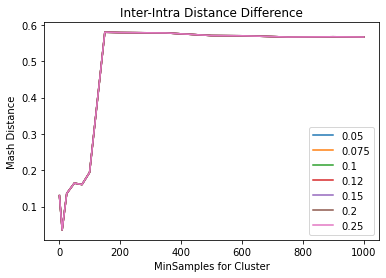

In [26]:
#Now we graph the behaviour of model performance. Here, difference in median intra and inter cluster distance.
eOpt=[0.05,0.075,0.1,0.12,0.15,0.2,0.25]
#plot(arange(0,15),HAllDiff[0:15],label="0.05")
#plot(arange(0,15),HAllDiff[15:30],label="0.075")
#plot(arange(0,15),HAllDiff[30:45],label="0.1")
#plot(arange(0,15),HAllDiff[45:60],label="0.12")
#plot(arange(0,15),HAllDiff[60:75],label="0.15")
#plot(arange(0,15),HAllDiff[75:90],label="0.2")
#plot(arange(0,15),HAllDiff[90:105],label="0.25")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HAllDiff[0:15],label="0.05")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HAllDiff[15:30],label="0.075")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HAllDiff[30:45],label="0.1")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HAllDiff[45:60],label="0.12")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HAllDiff[60:75],label="0.15")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HAllDiff[75:90],label="0.2")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HAllDiff[90:105],label="0.25")
title("Inter-Intra Distance Difference")
xlabel("MinSamples for Cluster")
ylabel("Mash Distance")
legend()

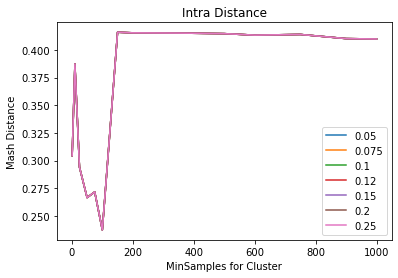

In [28]:
#Next, intra cluster median distance.
eOpt=[0.05,0.075,0.1,0.12,0.15,0.2,0.25]
#plot(arange(0,15),HAllSameDist[0:15],label="0.05")
#plot(arange(0,15),HAllSameDist[15:30],label="0.075")
#plot(arange(0,15),HAllSameDist[30:45],label="0.1")
#plot(arange(0,15),HAllSameDist[45:60],label="0.12")
#plot(arange(0,15),HAllSameDist[60:75],label="0.15")
#plot(arange(0,15),HAllSameDist[75:90],label="0.2")
#plot(arange(0,15),HAllSameDist[90:105],label="0.25")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HAllSameDist[0:15],label="0.05")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HAllSameDist[15:30],label="0.075")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HAllSameDist[30:45],label="0.1")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HAllSameDist[45:60],label="0.12")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HAllSameDist[60:75],label="0.15")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HAllSameDist[75:90],label="0.2")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HAllSameDist[90:105],label="0.25")
title("Intra Distance")
xlabel("MinSamples for Cluster")
ylabel("Mash Distance")
legend()

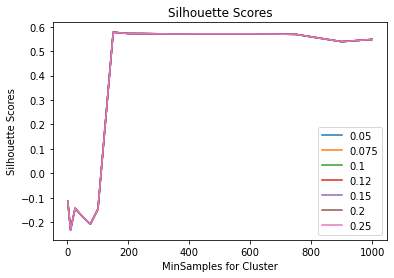

In [29]:
#FNow the silhouette scores.
eOpt=[0.05,0.075,0.1,0.12,0.15,0.2,0.25]
#plot(arange(0,15),HSS[0:15],label="0.05")
#plot(arange(0,15),HSS[15:30],label="0.075")
#plot(arange(0,15),HSS[30:45],label="0.1")
#plot(arange(0,15),HSS[45:60],label="0.12")
#plot(arange(0,15),HSS[60:75],label="0.15")
#plot(arange(0,15),HSS[75:90],label="0.2")
#plot(arange(0,15),HSS[90:105],label="0.25")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HSS[0:15],label="0.05")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HSS[15:30],label="0.075")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HSS[30:45],label="0.1")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HSS[45:60],label="0.12")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HSS[60:75],label="0.15")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HSS[75:90],label="0.2")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HSS[90:105],label="0.25")
title("Silhouette Scores")
xlabel("MinSamples for Cluster")
ylabel("Silhouette Scores")
legend()

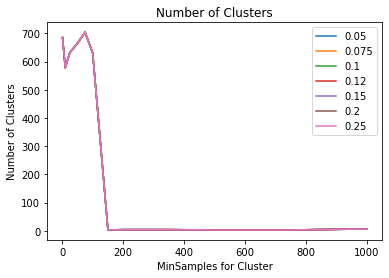

In [30]:
#Finally, the number of clusters.
eOpt=[0.05,0.075,0.1,0.12,0.15,0.2,0.25]
#plot(arange(0,15),HNumClusters[0:15],label="0.05")
#plot(arange(0,15),HNumClusters[15:30],label="0.075")
#plot(arange(0,15),HNumClusters[30:45],label="0.1")
#plot(arange(0,15),HNumClusters[45:60],label="0.12")
#plot(arange(0,15),HNumClusters[60:75],label="0.15")
#plot(arange(0,15),HNumClusters[75:90],label="0.2")
#plot(arange(0,15),HNumClusters[90:105],label="0.25")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HNumClusters[0:15],label="0.05")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HNumClusters[15:30],label="0.075")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HNumClusters[30:45],label="0.1")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HNumClusters[45:60],label="0.12")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HNumClusters[60:75],label="0.15")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HNumClusters[75:90],label="0.2")
plot([1,10,25,50,75,100,150,200,250,350,500,600,750,900,1000],HNumClusters[90:105],label="0.25")
title("Number of Clusters")
xlabel("MinSamples for Cluster")
ylabel("Number of Clusters")
legend()

#### Agglomerative Clustering

In [18]:
#Next one is agglomerative clustering. We only need to tune either the distance threshold or number of clusters.
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

#We define the list with the parameter (either of the two).
Params=linspace(0.01,1,40)

#We design variables to save the best silhouette score, number of clusters, and best parameter.
bestParam=0
bestSS=-2
bestNumClust=0

#We'll also save the output from every possible combination of parameters.
AllParams=[]
SS=[]
NumClusters=[]

#Now we test the parameters.
for param in Params:
        print(param)
#For each we generate the agglomerative clusterization.
        clustering=AgglomerativeClustering(distance_threshold=param, linkage='complete',affinity='precomputed',n_clusters=None).fit(distances)

#We save the number of clusters in NumClusters.
        NumClusters.append((max(clustering.labels_)+1))
        try:
            ss=silhouette_score(distances,clustering.labels_,metric='precomputed')
            print(ss)
            SS.append(ss)
        except ValueError:
            print(-1)
            SS.append(-1)

        #If the median intra cluster distance is smaller than the smallest one so far, the parameters for the best 
#clusterization are updated.
        if bestSS<ss:
            bestParam=param
            bestSS=ss
            bestNumClust=(max(clustering.labels_)+1)

0.01
0.02334568129423912
0.03538461538461538
0.09116568401515389
0.06076923076923077
0.13463380013238252
0.08615384615384615
0.15862749642483073
0.11153846153846153
0.15178872729627657
0.13692307692307693
0.14782045536750132
0.16230769230769232
0.14477655125707817
0.18769230769230769
0.13804190885026243
0.21307692307692308
0.13232563427992522
0.23846153846153847
0.12364474265507008
0.26384615384615384
0.13614414985254858
0.28923076923076924
0.13266745930828783
0.31461538461538463
0.12813807891150825
0.34
0.12419147564033077
0.36538461538461536
0.12520115248111502
0.39076923076923076
0.142855874765119
0.41615384615384615
0.13678186083387237
0.44153846153846155
0.13678186083387237
0.46692307692307694
0.13678186083387237
0.4923076923076923
0.13678186083387237
0.5176923076923077
0.13678186083387237
0.5430769230769231
0.13678186083387237
0.5684615384615385
0.13678186083387237
0.5938461538461538
0.13678186083387237
0.6192307692307693
0.13678186083387237
0.6446153846153846
0.13678186083387237

Text(0, 0.5, 'Silhouette Score')

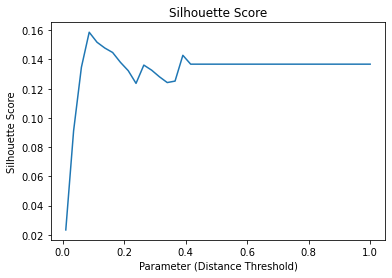

In [19]:
#Now the silhouette score.
plot(Params,SS)
title("Silhouette Score")
xlabel("Parameter (Distance Threshold)")
ylabel("Silhouette Score")
#yscale("log")

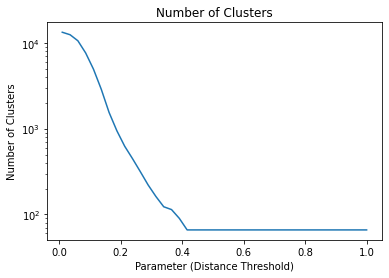

In [21]:
#Finally, the number of clusters.
plot(Params,NumClusters)
title("Number of Clusters")
xlabel("Parameter (Distance Threshold)")
ylabel("Number of Clusters")
yscale("log")